In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set Up

In [84]:
# libraries 
from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from pathlib import Path
from utils.analysis import *
from utils.chico_analysis import *
from utils.pb_analysis import *
import seaborn as sns

# Matplotlib settings
plt.style.use('ggplot')

# Not including svg to make in line less heavy

In [85]:

# Importing saved data from CSV 

subs_of_interest = ['AmItheAsshole', 'confessions', 'tifu']

def import_subreddit(subreddit):
    location_name = Path().cwd() / 'datasets' / f'{subreddit}.csv'
    return pd.read_csv(location_name)

subreddit_df = pd.concat([import_subreddit(subreddit) for subreddit in subs_of_interest], ignore_index=True)

def open_json_sub(subreddit_name):
    path_to_sub = Path().cwd() / 'data' / f'{subreddit_name}.json'
    with open(path_to_sub, 'r') as f:
        subreddit_dict = json.load(f)
    return subreddit_dict

subreddit_dict = {subreddit: open_json_sub(subreddit) for subreddit in subs_of_interest}


In [86]:
# Formatting the data as a resulst dictionary used in class

results = {}

for sub in subs_of_interest:    
    # posts = scraper.get_subreddit_posts(sub, limit=100, cache=True)
    # posts_df = create_posts_dataframe(subreddit_dict)
    
    tfidf_results = tfidf_df(subreddit_df[subreddit_df['subreddit'] == sub], include_selftext=True)
    # tfidf_results = tfidf_analyze_subreddit(posts)
    tf_idf_scores = get_mean_tfidf(
        tfidf_matrix=tfidf_results['tfidf_matrix'],
        feature_names=tfidf_results['feature_names'],
        return_df=True
    )
    results[sub] = {"posts_df":subreddit_df[subreddit_df['subreddit'] == sub],
                    "tfidf_results":tfidf_results,
                    "tf_idf_scores":tf_idf_scores}



# 1. Anaysis using previous code

Includes 
1. Jaccard Similarity and a top common terms between the subreddits 
2. MDS visualization of top terms 
3. TSNE  visualization of terms, highlighting top terms 

Time series plots not included because we aren't looking at reddits over a long-enough period of time. 
Classification - Naive Bayes and K Mean clustering -- not included here, included elsewhere. 

## Jaccard Similarity and Common Words

In [87]:
# Extract the vocabulary for each subreddit
vocabularies = {sub: set(results[sub]['tfidf_results']['feature_names']) for sub in subs_of_interest}

# Get the intersection of the vocabularies
common_vocab = set.intersection(*vocabularies.values())

# Report analytics
print(f"Number of common terms across all subreddits: {len(common_vocab)}")
print(f"Common terms: {', '.join(list(common_vocab)[:10])}...")  # Display first 10 common terms

# Calculate Jaccard similarity for each pair of subreddits
for sub1 in subs_of_interest:
    for sub2 in subs_of_interest:
        if sub1 > sub2:
            intersection = vocabularies[sub1].intersection(vocabularies[sub2])
            union = vocabularies[sub1].union(vocabularies[sub2])
            jaccard_similarity = len(intersection) / len(union)
            print(f"Jaccard similarity between {sub1} and {sub2}: {jaccard_similarity:.3f}")

# Report unique terms for each subreddit
for sub in subs_of_interest:
    unique_terms = vocabularies[sub] - common_vocab
    print(f"Number of unique terms in {sub}: {len(unique_terms)}")
    print(f"Unique terms in {sub}: {', '.join(list(unique_terms)[:10])}...")  # Display first 10 unique terms

Number of common terms across all subreddits: 635
Common terms: matter, block, charge, mistake, mean, member, bar, yet, beautiful, experience...
Jaccard similarity between confessions and AmItheAsshole: 0.549
Jaccard similarity between tifu and AmItheAsshole: 0.591
Jaccard similarity between tifu and confessions: 0.570
Number of unique terms in AmItheAsshole: 365
Unique terms in AmItheAsshole: uncle, actual, force, roommate, effort, emily, transfer, base, special, consequence...
Number of unique terms in confessions: 365
Unique terms in confessions: virginity, rub, popular, force, internet, sexy, beat, glad, financially, till...
Number of unique terms in tifu: 365
Unique terms in tifu: tub, actual, roommate, glass, worried, ate, flavor, base, special, google...


In [88]:
import pandas as pd
import numpy as np

# Create a dataframe for the common terms
common_terms_df = pd.DataFrame(index=list(common_vocab))

# Add TF-IDF scores for each subreddit
for sub in subs_of_interest:
    common_terms_df[sub] = results[sub]['tf_idf_scores'].reindex(common_vocab)['score']

# Calculate the average TF-IDF score (mean)
common_terms_df['average'] = common_terms_df.mean(axis=1)

# Sort by the average score
common_terms_df = common_terms_df.sort_values(by='average', ascending=False)

# Report the top 5 words
top_5_words = common_terms_df.head(5)
print(top_5_words)

        AmItheAsshole  confessions      tifu   average
get          0.055759     0.050276  0.059213  0.055082
like         0.042726     0.058079  0.043713  0.048173
say          0.059122     0.034365  0.040530  0.044673
friend       0.051731     0.032340  0.034641  0.039571
want         0.043500     0.038724  0.030863  0.037696


## MDS Visualization of TF_IDF matrix for top terms 

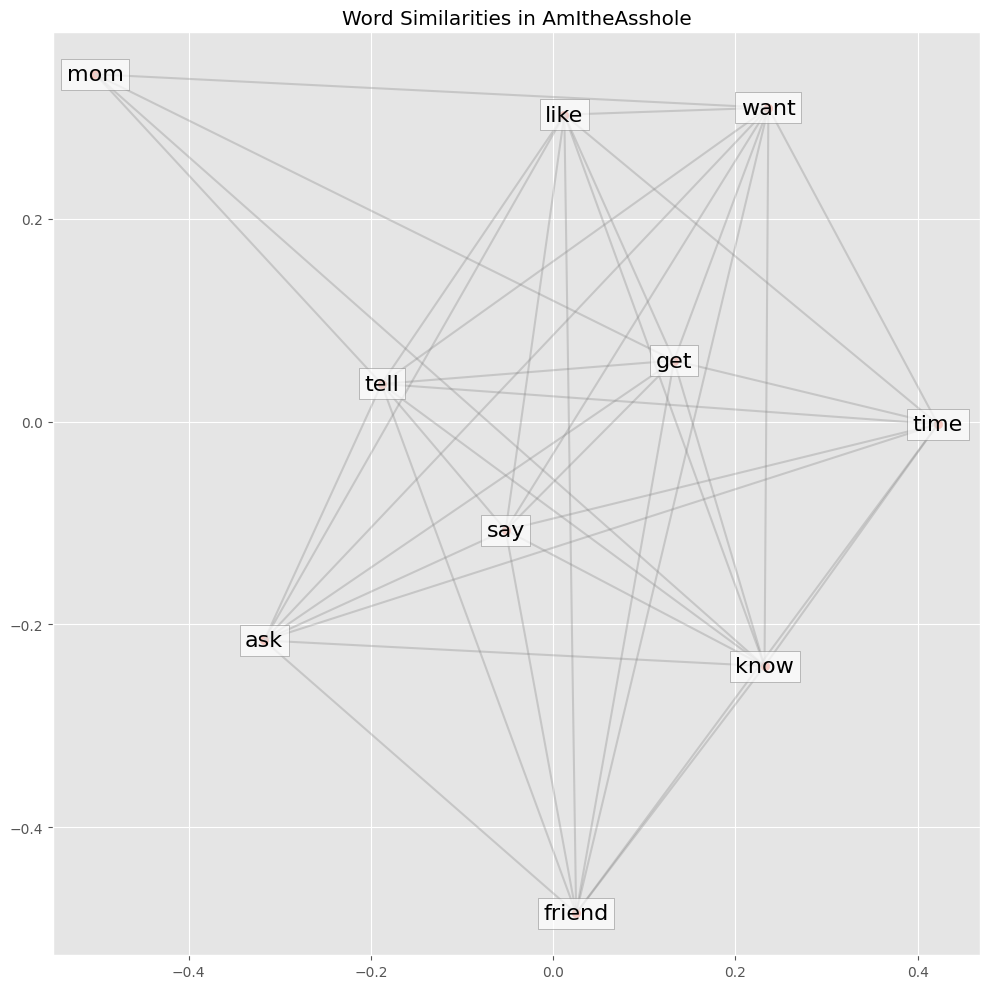

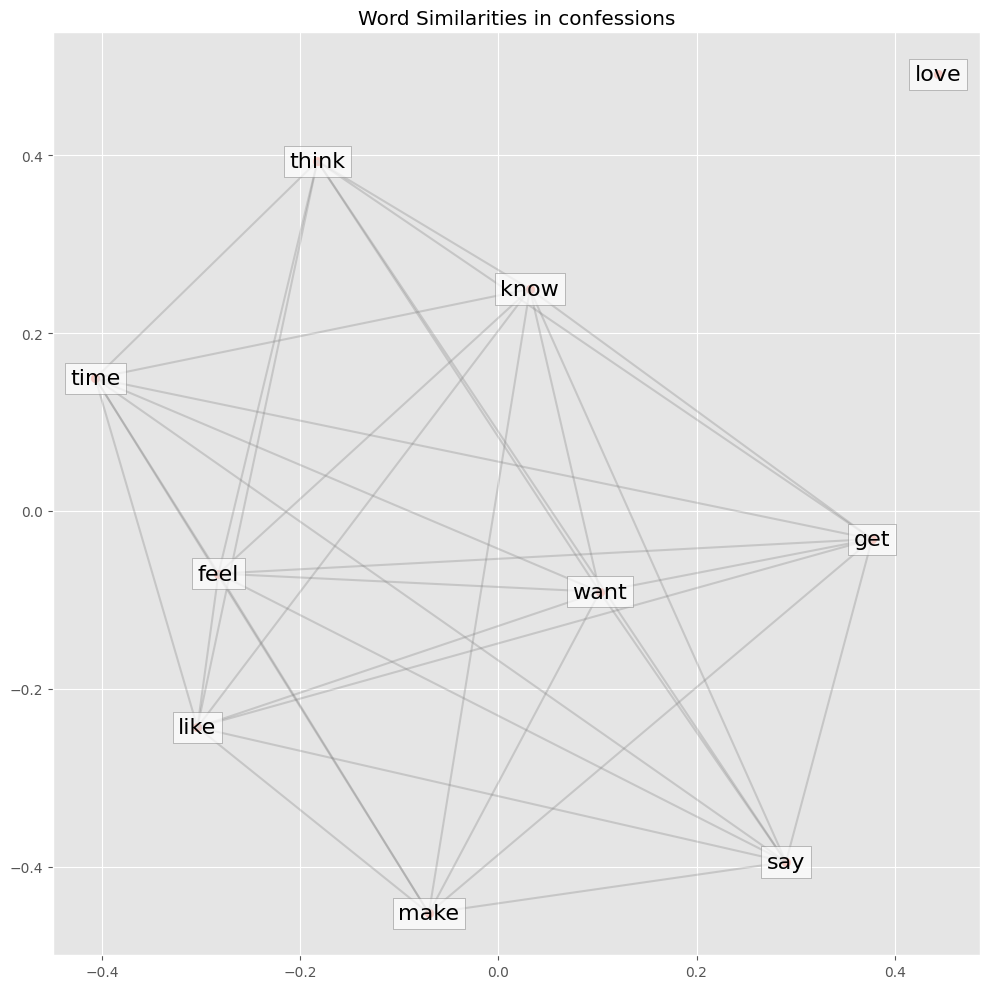

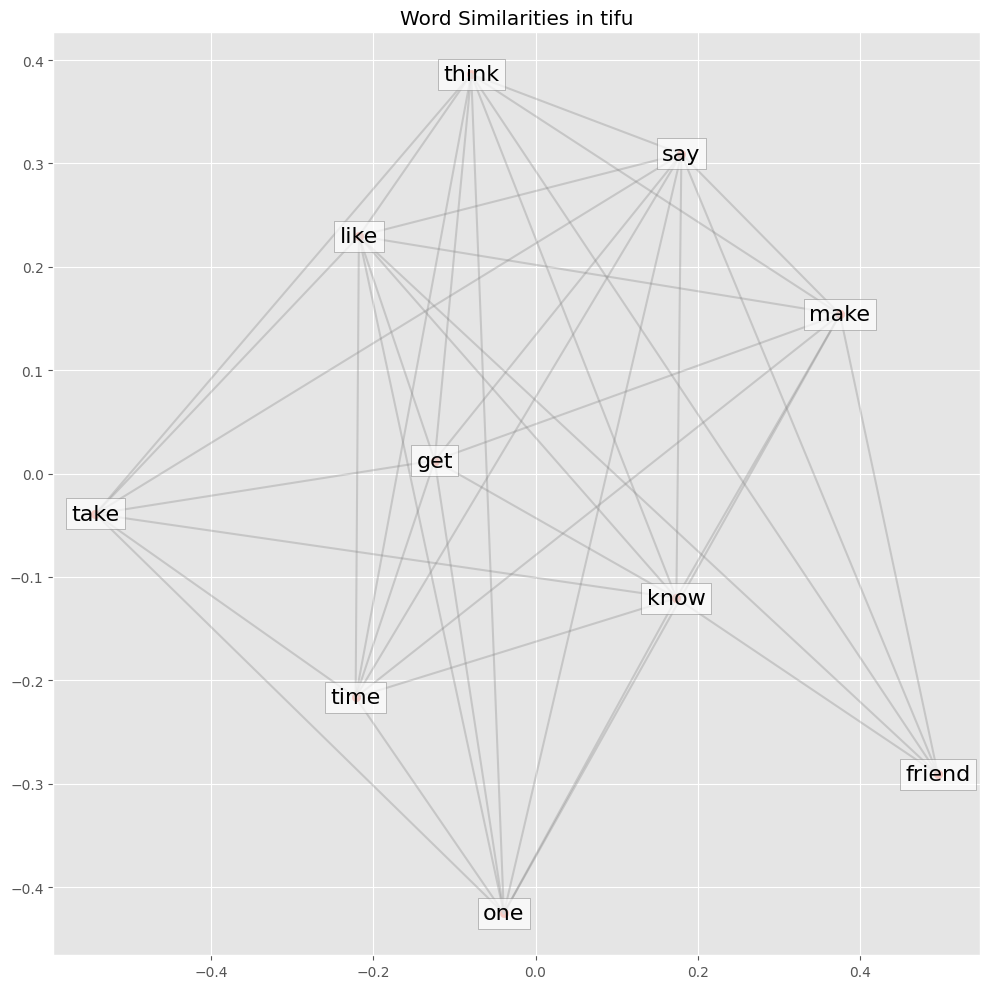

In [89]:
from utils.analysis import plot_word_similarities_mds

for sub in subs_of_interest:
    fig, ax = plot_word_similarities_mds(results[sub]['tfidf_results']['tfidf_matrix'], 
                                     results[sub]['tfidf_results']['feature_names'],
                                     n_terms=10, # Try changing this value
                                     title=sub)
    plt.show()

## TSNE of TF-IDF - plots all temrs but highlights top terms

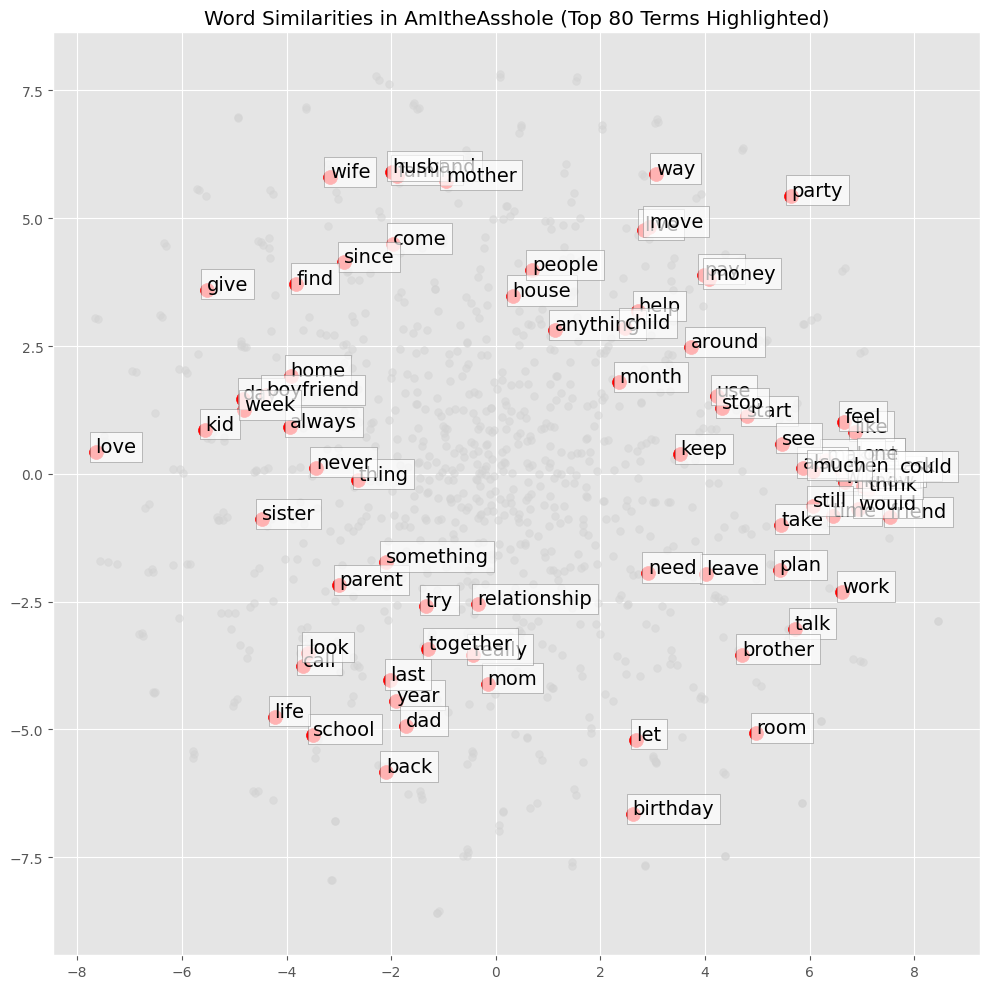

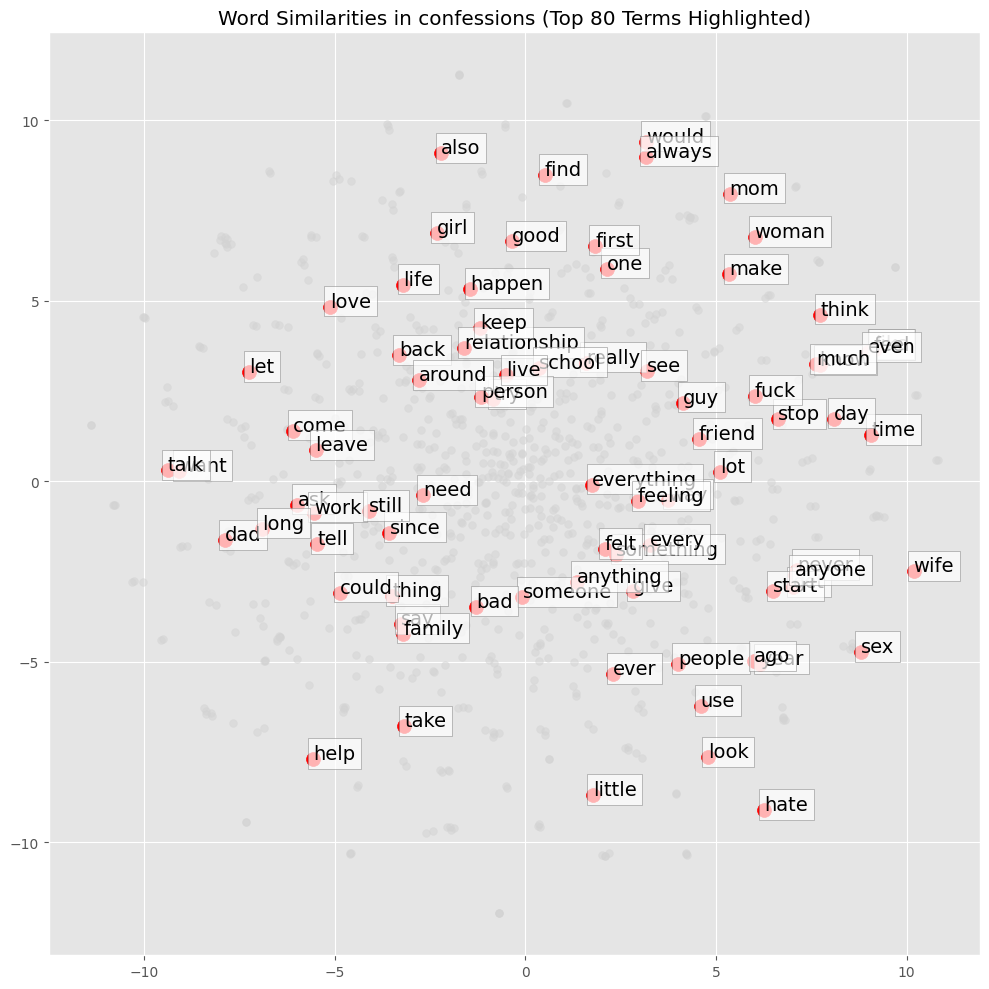

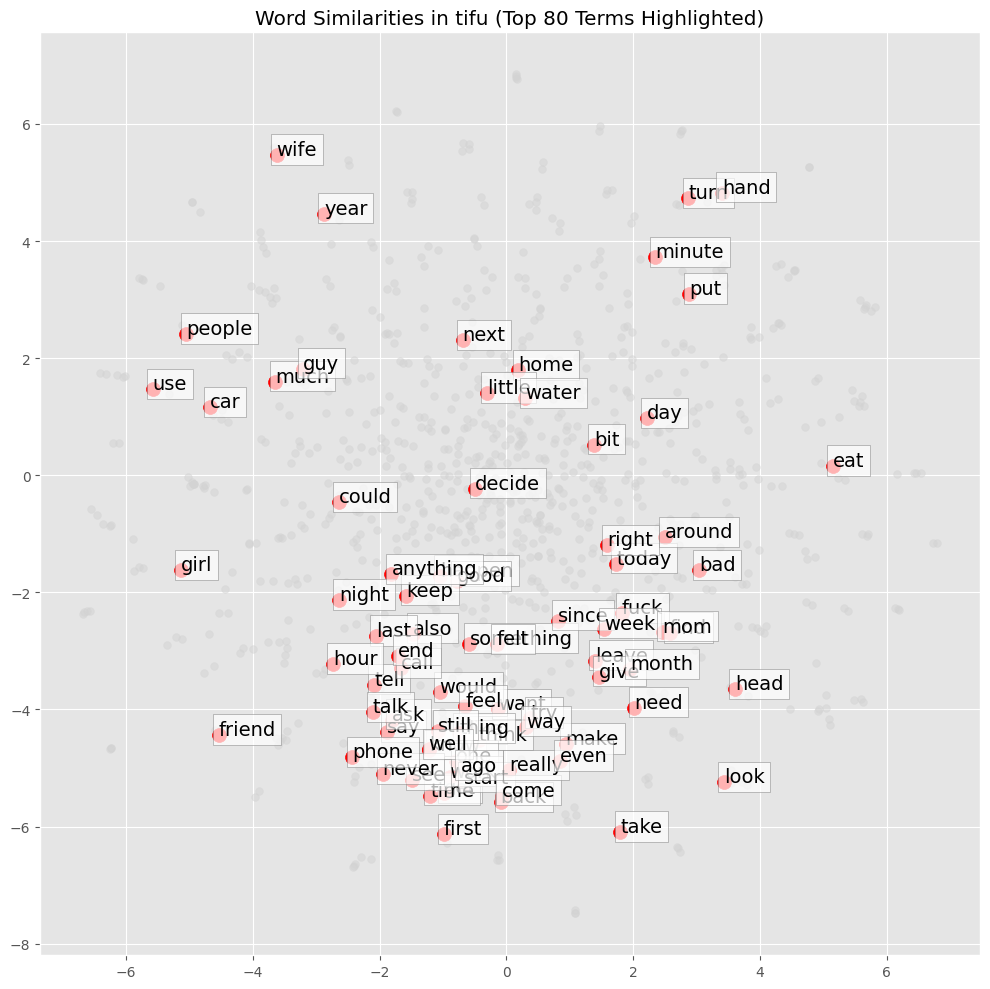

In [90]:
from utils.analysis import plot_word_similarities_tsne

for sub in subs_of_interest:
    fig, ax = plot_word_similarities_tsne(results[sub]['tfidf_results']['tfidf_matrix'], 
                                     results[sub]['tfidf_results']['feature_names'],
                                     n_highlight=80, # Try changing this value
                                     title=sub)
    plt.show()

# 2. Focus of Sub reddit: Family, Friend, Partner

2. Anaysis by topic: Family, Friend, Partner

In [91]:
from utils.pb_analysis import*

keywords = {
    'partner': r'\b(wife|husband|spouse|partner|girlfriend|boyfriend|fiancee|fiance|ex|bf|gf|ex-wife|ex-husband|ex-girlfriend|ex-boyfriend|ex-fiancee|ex-fiance|companion|significant other|s.o.|s.o|lover)\b',
    'family': r'\b(mom|dad|mother|father|sister|brother|aunt|uncle|cousin|niece|nephew|grandmother|grandfather|grandma|grandpa|daughter|son|child|children|kid|kids|parent|parents|family|fam|mum)\b',
    'friend': r'\b(friend|friends|buddy|buddies|pal|pals|mate|mates|companion|companions|acquaintance|acquaintances|chum|chums|confidant|confidants|ally|allies|associate|associates|roommate|roommates|colleague|colleagues|coworker|coworkers|teammate|teammates|classmate|neighbor|team|teams)\b'
}

# Apply the function to each subreddit
for sub in subs_of_interest:
    results[sub]['posts_df'].loc[:, ['partner', 'family', 'friend']] = add_keyword_columns(results[sub]['posts_df'], keywords).loc[:, ['partner', 'family', 'friend']]

# Print value counts for each category
for sub in subs_of_interest:
    print(sub)
    print(results[sub]['posts_df'][["partner", "family", "friend"]].value_counts())
    print("\n")


AmItheAsshole
partner  family  friend
True     True    False     121
                 True      118
         False   True       69
False    True    False      59
                 True       49
         False   True       38
True     False   False      34
False    False   False      12
Name: count, dtype: int64


confessions
partner  family  friend
False    False   False     139
True     False   False      87
         True    False      53
False    True    False      52
         False   True       44
True     True    True       39
         False   True       36
False    True    True       30
Name: count, dtype: int64


tifu
partner  family  friend
False    False   False     96
True     False   False     87
         True    False     73
False    True    False     67
True     True    True      67
         False   True      44
False    False   True      43
         True    True      23
Name: count, dtype: int64




/Users/priyansha/Documents/Oxford/Term1/SDS_in_python/Week03-04/subreddit-comparison-project/utils/pb_analysis.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return df
/Users/priyansha/Documents/Oxford/Term1/SDS_in_python/Week03-04/subreddit-comparison-project/utils/pb_analysis.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df
/Users/priyansha/Documents/Oxford/Term1/SDS_in_python/Week03-04/subreddit-comparison-project/utils/pb_analysis.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return df
/Users/priyansha/Documents/Oxford/Term1/SDS_in_python/We

In [92]:
# concat 3 dataframes: results['tifu']['posts_df'],  results['AmItheAsshole']['posts_df'], and results['confession']['posts_df']

df = pd.concat([results['tifu']['posts_df'], results['AmItheAsshole']['posts_df'], results['confessions']['posts_df']], ignore_index=True)

In [93]:
# Partner Only, Family Only, Friend Only, All Three, None, Two of Three
df['relationship'] = np.nan
df['relationship'] = df['relationship'].astype('object')
df.loc[(df['partner'] == True) & (df['family'] == False) & (df['friend'] == False), 'relationship'] = 'Partner Only'
df.loc[(df['partner'] == False) & (df['family'] == True) & (df['friend'] == False), 'relationship'] = 'Family Only'
df.loc[(df['partner'] == False) & (df['family'] == False) & (df['friend'] == True), 'relationship'] = 'Friend Only'
df.loc[(df['partner'] == True) & (df['family'] == True) & (df['friend'] == True), 'relationship'] = 'All Three'
df.loc[(df['partner'] == False) & (df['family'] == False) & (df['friend'] == False), 'relationship'] = 'None'
df.loc[(df['partner'] == True) & (df['family'] == True) & (df['friend'] == False), 'relationship'] = 'Partner and Family'
df.loc[(df['partner'] == True) & (df['family'] == False) & (df['friend'] == True), 'relationship'] = 'Partner and Friend'
df.loc[(df['partner'] == False) & (df['family'] == True) & (df['friend'] == True), 'relationship'] = 'Family and Friend'

In [94]:
# cross tabe of relationship and subreddit
crosstab = pd.crosstab(df['subreddit'], df['relationship'])

# reorder columns in crosstab
crosstab = crosstab[['All Three', 'Partner Only', 'Family Only', 'Friend Only', 'Partner and Family', 'Partner and Friend', 'Family and Friend', 'None']]
crosstab

relationship,All Three,Partner Only,Family Only,Friend Only,Partner and Family,Partner and Friend,Family and Friend,None
subreddit,,,,,,,,
AmItheAsshole,118,34,59,38,121,69,49,12
confessions,39,87,52,44,53,36,30,139
tifu,67,87,67,43,73,44,23,96


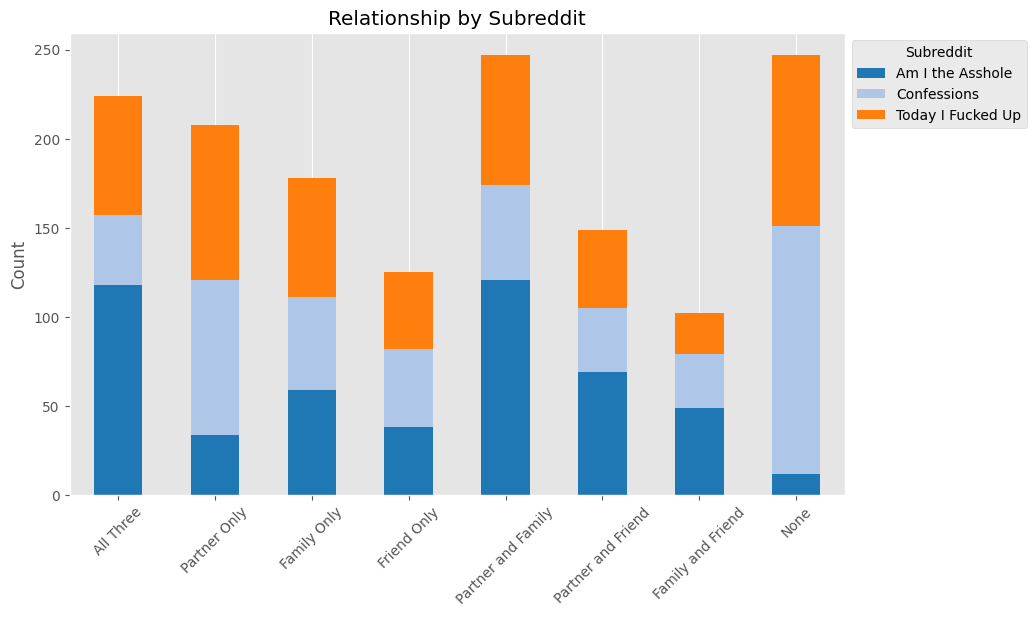

In [95]:
# Plot the stacked bar graph with custom colors partner, family, friend columns with subreddit in legend

# Define custom colors
colors = plt.get_cmap('tab20').colors

# Plot the stacked bar graph with custom colors
crosstab.T.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title("Relationship by Subreddit")
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=0)

# Update legend with custom names
names = {'AmItheAsshole': 'Am I the Asshole', 'confessions': 'Confessions', 'tifu': 'Today I Fucked Up'}
plt.legend(title='Subreddit', labels=[names[sub] for sub in crosstab.index], bbox_to_anchor=(1, 1))

plt.grid(axis='y')

# make x axis labels 45 degree
plt.xticks(rotation=45)

# make figures directory if it does not exist
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/relationship_by_subreddit.svg', bbox_inches='tight')

plt.show()

In [96]:
from utils.pb_analysis import analyze_column_by_subreddit

for column in ['partner', 'family', 'friend']:
    print(f"{column.capitalize()}")
    analyze_column_by_subreddit(df, column)
    print(crosstab)
    print()
    print()

Partner
Chi-square: 56.31
p-value: 0.0000
Degrees of freedom: 2
relationship   All Three  Partner Only  ...  Family and Friend  None
subreddit                               ...                         
AmItheAsshole        118            34  ...                 49    12
confessions           39            87  ...                 30   139
tifu                  67            87  ...                 23    96

[3 rows x 8 columns]


Family
Chi-square: 114.47
p-value: 0.0000
Degrees of freedom: 2
relationship   All Three  Partner Only  ...  Family and Friend  None
subreddit                               ...                         
AmItheAsshole        118            34  ...                 49    12
confessions           39            87  ...                 30   139
tifu                  67            87  ...                 23    96

[3 rows x 8 columns]


Friend
Chi-square: 65.62
p-value: 0.0000
Degrees of freedom: 2
relationship   All Three  Partner Only  ...  Family and Friend  None
su

# 3. Age and Gender

In [97]:
# sample text to test the function
sample_text = pd.DataFrame(df['selftext'].iloc[[30, 22, 23, 67, 56]]) 
sample_text['age'] = pd.Series([32, 27, 22, 29, 18], index=sample_text.index)
sample_text['gender'] = pd.Series(['M', 'NB', 'M', 'M', 'F'], index=sample_text.index)
print(sample_text)

                                             selftext  age gender
30  Last weekend my GF (32F) and I (32M) went to a...   32      M
22  I (27NB) took today off work to drive my partn...   27     NB
23  So, I (22M) matched with this beautiful girl (...   22      M
67  I (M29) went to the doctors today due to some ...   29      M
56  I (18F) just wanted to say that I don't regret...   18      F


In [102]:
from utils.pb_analysis import *

# Apply function to 'selftext' column and create new columns 'age' and 'gender'
sample_text[['age', 'gender']] = sample_text['selftext'].apply(extract_age_gender)
print(sample_text)

                                             selftext  age gender
30  Last weekend my GF (32F) and I (32M) went to a...   32      M
22  I (27NB) took today off work to drive my partn...   27     NB
23  So, I (22M) matched with this beautiful girl (...   22      M
67  I (M29) went to the doctors today due to some ...   29      M
56  I (18F) just wanted to say that I don't regret...   18      F


In [104]:
# apply to df 
df[['age', 'gender']] = df['selftext'].apply(extract_age_gender)


In [105]:
# describe age and gender columns
print(df['age'].describe())
print()
print(df['gender'].describe())


count    145.000000
mean      23.931034
std        6.400581
min       14.000000
25%       19.000000
50%       23.000000
75%       28.000000
max       54.000000
Name: age, dtype: float64

count     145
unique      3
top         F
freq       89
Name: gender, dtype: object


# 4. Length of Posts

In [106]:
# mean length of selftext by subreddit
df.groupby('subreddit')['selftext'].apply(lambda x: x.str.len().mean())


subreddit
AmItheAsshole    1988.240000
confessions      1294.441667
tifu             2085.414000
Name: selftext, dtype: float64

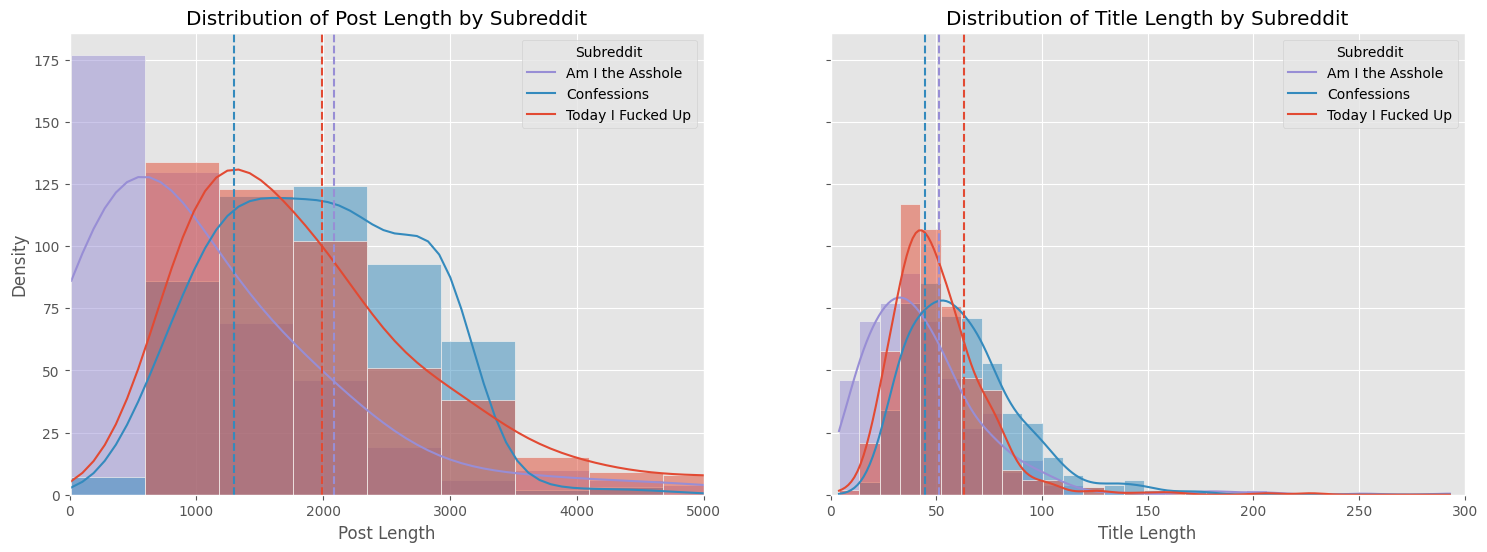

In [107]:
# plot the distribution of selftext length by subreddit

# create length of selftext and title columns
df['selftext_len'] = df['selftext'].str.len()
df['title_len'] = df['title'].str.len()

# plot the distribution of selftext length and title length by subreddit
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)


# Plot selftext length distribution
sns.histplot(data=df, x='selftext_len', hue='subreddit', bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Post Length by Subreddit")
axes[0].set_xlabel("Post Length")
axes[0].set_ylabel("Density")

# Add mean line for each subreddit using legend color
for sub in subs_of_interest:
    mean_len = df[df['subreddit'] == sub]['selftext_len'].mean()
    axes[0].axvline(mean_len, color=sns.color_palette()[subs_of_interest.index(sub)], linestyle='--', label=f"{sub.capitalize()} Mean")


# Plot title length distribution
sns.histplot(data=df, x='title_len', hue='subreddit', bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Title Length by Subreddit")
axes[1].set_xlabel("Title Length")

# Add mean line for each subreddit using legend color
for sub in subs_of_interest:
    mean_len = df[df['subreddit'] == sub]['title_len'].mean()
    axes[1].axvline(mean_len, color=sns.color_palette()[subs_of_interest.index(sub)], linestyle='--', label=f"{sub.capitalize()} Mean")


# Set x-axis limit
axes[0].set_xlim(0, 5000)
axes[1].set_xlim(0, 300)

# Add legend
names = {'AmItheAsshole': 'Am I the Asshole', 'confessions': 'Confessions', 'tifu': 'Today I Fucked Up'}
axes[0].legend(title='Subreddit', labels=[names[sub] for sub in subs_of_interest])
axes[1].legend(title='Subreddit', labels=[names[sub] for sub in subs_of_interest])

# Save the plot as svg
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/selftext_and_title_length.svg')

plt.show()

# 5. Individual vs Inclusive Pronoun: 'I' vs 'We' counts

In [108]:
# count number of 'we' and 'I' words in selftext
df['we_count'] = df['selftext'].str.lower().str.count(r'\bwe\b')
df['I_count'] = df['selftext'].str.lower().str.count(r'\bi\b')

In [109]:
# describe the 'we_count' and 'I_count' columns
df[['we_count', 'I_count']].describe()

,we_count,I_count
count,1480.000000,1480.000000
mean,2.407432,19.578378
std,3.913476,15.432483
min,0.000000,0.000000
25%,0.000000,10.000000
50%,1.000000,17.000000
75%,3.000000,26.000000
max,38.000000,184.000000


In [110]:
# grouped describe of 'we_count' and 'I_count' columns by subreddit
df.groupby('subreddit')[['we_count', 'I_count']].describe()

we_count                         ... I_count                   
                 count    mean       std  min  ...     25%   50%   75%    max
subreddit                                      ...                           
AmItheAsshole    500.0  3.1180  3.728791  0.0  ...    12.0  18.0  25.0   77.0
confessions      480.0  1.6125  3.861897  0.0  ...     4.0  11.0  21.0  184.0
tifu             500.0  2.4600  4.007058  0.0  ...    13.0  19.0  29.0  128.0

[3 rows x 16 columns]

In [111]:
# normalize by the length of the selftext
df['we_count_norm'] = df['we_count'] / df['selftext'].str.split().str.len()
df['I_count_norm'] = df['I_count'] / df['selftext'].str.split().str.len()

# convert to percentage
df['we_count_norm'] = df['we_count_norm'] * 100
df['I_count_norm'] = df['I_count_norm'] * 100

# grouped describe of 'we_count_norm' and 'I_count_norm' columns by subreddit
df.groupby('subreddit')[['we_count_norm', 'I_count_norm']].describe()

we_count_norm                      ... I_count_norm                     
                      count      mean       std  ...          50%       75%        max
subreddit                                        ...                                  
AmItheAsshole         500.0  0.777080  0.852565  ...     5.239051  6.451613  10.924370
confessions           480.0  0.524554  1.104187  ...     6.772494  8.763473  20.000000
tifu                  500.0  0.550038  0.737806  ...     5.706884  6.987995  12.834225

[3 rows x 16 columns]

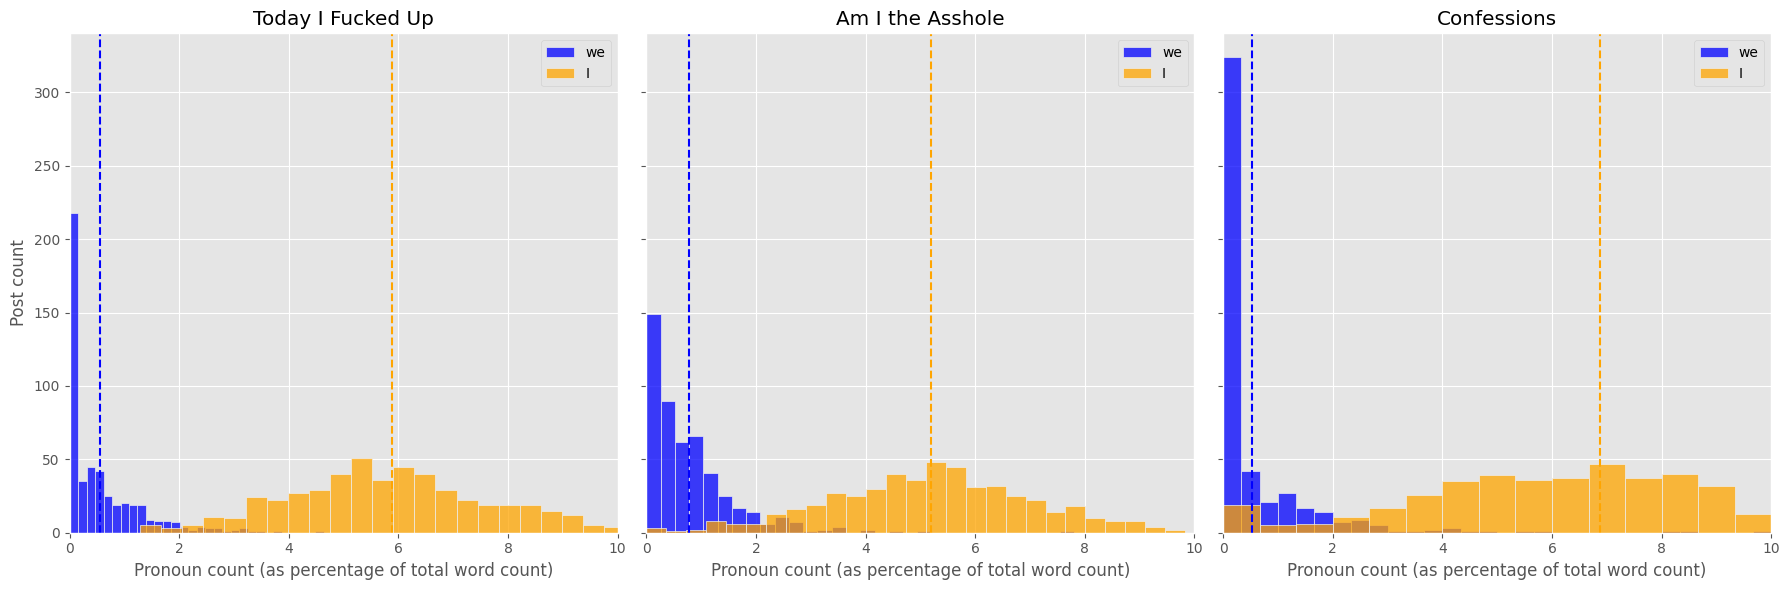

In [117]:
# plot the normalized we and I counts for each subreddit with shared x axis and y axis and mean line

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for i, subreddit in enumerate(df['subreddit'].unique()):
    sns.histplot(df[df['subreddit'] == subreddit]['we_count_norm'], ax=ax[i], label='we', color='blue', kde=False, bins=30)
    sns.histplot(df[df['subreddit'] == subreddit]['I_count_norm'], ax=ax[i], label='I', color='orange', kde=False, bins=30)
    ax[i].set_title(f"{subreddit.capitalize()}")
    ax[i].set_ylabel("Post count")
    ax[i].set_xlabel("Pronoun count (as percentage of total word count)")
    ax[i].set_xlim(0, 10)
    ax[i].legend()

    # custom title for each subplot
    names = {'AmItheAsshole': 'Am I the Asshole', 'confessions': 'Confessions', 'tifu': 'Today I Fucked Up'}
    ax[i].set_title(names[subreddit])

    # add mean line for I_count_norm and we_count_norm for each subreddit
    ax[i].axvline(df[df['subreddit'] == subreddit]['we_count_norm'].mean(), color='blue', linestyle='--')
    ax[i].axvline(df[df['subreddit'] == subreddit]['I_count_norm'].mean(), color='orange', linestyle='--')

plt.tight_layout()

# save as svg
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/pronoun_counts.svg')

plt.show()



# 6. Question vs Statement Posts

In [115]:
# create a column with whether or not a post has a question mark
df['question'] = df['selftext'].str.contains(r'\?')

# if true than "question" else "statement"
df['question'] = df['question'].map({True: 'Question', False: 'Statement'})

In [118]:
# chi squared test of independence between subreddit and question column

from utils.pb_analysis import analyze_column_by_subreddit

analyze_column_by_subreddit(df, column)

Chi-square: 65.62
p-value: 0.0000
Degrees of freedom: 2


,False,True
subreddit,,
Am I the Asshole,45.200000,54.800000
Confessions,68.958333,31.041667
Today I Fucked Up,64.600000,35.400000
